**Цель микросервиса:** система классификации типа математической задачи

---



**Команда проекта:**

  * Кулибаба Степан

  * Пирахмедов Тимур



---

# Подготовка

In [ ]:
# Установка необходимых библиотек
!pip install pymorphy2
!python -m spacy download ru_core_news_sm
!pip install yargy
!pip install umap-learn
!pip install catboost

In [ ]:
# Импортирование необходимых библиотек
import requests
from bs4 import BeautifulSoup
# -
import numpy as np
import pandas as pd
import pickle
# -
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import spacy
from nltk import FreqDist
from nltk.util import ngrams
# -
import matplotlib.pyplot as plt
import seaborn as sns
import umap
# -
import pymorphy2
import os
import re
import time
from tqdm import tqdm
import random
import unicodedata
# -
import string
from string import ascii_letters
# -
from gensim.models import Word2Vec as w2v
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
# -
from google.colab import drive, userdata
import warnings
# -
from yargy import Parser, rule, and_, or_
from yargy.interpretation import fact, attribute
from yargy.predicates import normalized, dictionary
from yargy.pipelines import morph_pipeline
from yargy.relations import main
from yargy.predicates import in_

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')
stop_words = stopwords.words('russian')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Подключаем гугл диск
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Определяем путь до данных
path_to_folder = userdata.get('path_to_folder_ppsh')

# Парсинг данных
материал:

    https://www.problems.ru/
    https://mathus.ru/

In [ ]:
# Формуриуем датасет
data = pd.DataFrame({"Путь до файла": [],
                     "Тема": []})

## Mathus

In [ ]:
# Объединяем уже предобработанные данные с MathUs
def list_files_in_directory(directory):
    global data
    if not os.path.exists(directory):
        print(f"Директория '{directory}' не существует.")
        return

    for root, dirs, files in os.walk(directory):
        print(f"Папка: {root}")
        path_to_file = []
        for file in files:
            path_to_file.append(os.path.join(root, file))
            print(file)

        data = pd.concat([data, pd.DataFrame({"Путь до файла": path_to_file,
                          "Тема": [root.split('/')[-1]]*len(path_to_file)})])

directory_path = path_to_folder + '/Dataset/Parsing/'
list_files_in_directory(directory_path)

Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Оценка+пример
Оценка+Пример-1.txt
Оценка+Пример-2.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Инвариант 
invariant.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Многочлен
polynom.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Комбинаторика 
sumprod.txt
apc.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Теория чисел
07-euclid.txt
02_malaja_teorema_Ferma_upr.txt
nodinok.txt
ostear.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Дирихле
dirihle.txt
pridir.txt
Папка: /content/drive/MyDrive/Проекты/ППШ/Dataset/Parsing/Геометрия
геома.txt
2016_04_28_gomotetia.txt


In [ ]:
# Обрабатываем данные
data_with_task = pd.DataFrame({"Задача": [], "Тема": []})
pattern = re.compile(r'\b\d+[.)]\s*(?:\([^)]*\))?.*?(?=(?:\b\d+[.)])|\b\d+\s*-\s*\d+[.)])', re.DOTALL)

for index, row in data.iterrows():
  with open(row['Путь до файла'], 'r') as f:
      text = f.read()
  task = pattern.findall(text)
  data_with_task = pd.concat([data_with_task,
                              pd.DataFrame({"Задача": task,
                                            "Тема": [row['Тема']]*len(task)})])

In [ ]:
data_with_task = data_with_task.reset_index().drop(columns=['index'])

In [ ]:
data_with_task

,Задача,Тема
0,1. Какое наибольшее число трёхклеточных уголко...,Оценка+пример
1,"66. Значит, число уголков не\nбольше 21 (оценк...",Оценка+пример
2,"21.\n Логика рассуждения ясна: мы показали, ...",Оценка+пример
3,2. Каким наименьшим числом монет в 3 и 5 копее...,Оценка+пример
4,40). Семь\nпятикопеечных монет и одна трёхкопе...,Оценка+пример
...,...,...
1387,6. Даны угол 𝐴𝐵𝐶 и точка 𝑀 внутри его. Построй...,Геометрия
1388,7. Две окружности касаются в точке 𝐾. Через то...,Геометрия
1389,8. На каждом из оснований 𝐴𝐷 и 𝐵𝐶 трапеции 𝐴𝐵𝐶...,Геометрия
1390,9. Четырёхугольник разрезан диагоналями на чет...,Геометрия


In [ ]:
data_with_task.groupby('Тема').agg('count')

,Задача
Тема,
Геометрия,78
Дирихле,44
Инвариант,46
Комбинаторика,264
Многочлен,369
Оценка+пример,325
Теория чисел,266


In [ ]:
data_with_task.to_csv('data.csv', sep='@')

## Problems

Парисм данные с problems.ru

In [ ]:
data_problems = pd.DataFrame({'Задача': [], "Тема": []})
PROBLEMS = 'https://www.problems.ru/view_by_subject_new.php?parent={}&start={}'
url = ((192, 'Графы'),
       (603, 'Геометрия'), (379, 'Геометрия'), (381, 'Геометрия',), (382, 'Геометрия',), (404, 'Геометрия',),
       (1902, 'Оценка+пример'),
       (110, 'Многочлен'), (160, 'Многочлен'), (1286, 'Многочлен'), (958, 'Многочлен'), (1069, 'Многочлен'), (1069, 'Многочлен'),
       (188, "Комбинаторика"),
       (134, 'Теория чисел'),
       (220, 'Инвариант'),
       (216, "Дирихле")
       )

old_paragraph_list = [0]
for urls in url:
    for page in tqdm(range(0, 10**4, 5)):

        url_s = PROBLEMS.format(urls[0], page)
        response = requests.get(url_s)

        html = response.content

        soup = BeautifulSoup(html, 'html.parser')
        paragraphs = soup.find_all('p')

        paragraph_list = [paragraph.get_text() for paragraph in paragraphs if paragraph.get_text()]

        if old_paragraph_list == paragraph_list:
          break
        old_paragraph_list = paragraph_list

        data_problems = pd.concat([data_problems, pd.DataFrame({'Задача': paragraph_list,
                                                                "Тема": urls[1]})])

        time.sleep(1.5)

  6%|▌         | 119/2000 [05:46<1:31:23,  2.92s/it]


In [ ]:
data_problems = data_problems.drop_duplicates()

In [ ]:
data_problems.to_excel('data_problems.xlsx')

In [ ]:
data_problems.groupby('Тема').agg('count')

,Задача
Тема,
Геометрия,371
Графы,384
Дирихле,441
Инвариант,235
Комбинаторика,1020
Многочлен,426
Теория чисел,2396


# DataCleaning

In [ ]:
# Формируем общий датасет
mathus = pd.read_csv(path_to_folder + '/Dataset/MathUs.csv', sep='@').drop(columns=['Unnamed: 0'])
problems = pd.read_excel(path_to_folder + '/Dataset/data_problems.xlsx').drop(columns=['Unnamed: 0'])\
            .rename(columns={"Задача": "Задание"})
data = pd.concat([mathus, problems])

In [ ]:
data.to_csv('merge_data.csv', sep='@')

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.rename(columns={'Задание': 'task',
                     'Тема': 'topic'},
            inplace=True)

In [ ]:
data.groupby('topic').agg('count')

,task
topic,
Геометрия,426
Графы,384
Дирихле,479
Инвариант,267
Комбинаторика,1159
Многочлен,485
Оценка+Пример,65
Теория чисел,2503


In [ ]:
nlp = spacy.load("ru_core_news_sm")

In [ ]:
# Пишем функции для обработки строк
with open(path_to_folder + '/name-to-name.pickle', 'rb') as file:
    name_to_name_dict = pickle.load(file)


def replace_symbol(text):
    text = re.sub(r'прислать[^)]*\)', '', text)
    text = re.sub(r'[\d′‖√∠ω№◦⊥→×]', lambda match: name_to_name_dict[match.group()], text)
    return text


def del_garbage(text):
    return text.strip('.,)?.<*&^%$#@!~')\
               .replace(u'\u00A0', ' ')\
               .replace(u'\x0c', ' ')\
               .replace('\n', '').replace('\t', '')\
               .replace('\r', '')


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def filters_dig(text):
    pattern = r"прислать[^)]*\)"
    help_text = re.sub(pattern, "", text)
    help_text = text.split()
    if len(text.replace(' ', '')) > 1 and '\xa0' not in text and len(help_text) > 1:
      try:
        if help_text[0] == 'Задача':
          return text[text.find(')')+1:]
        float(help_text[0][:-1])
        if help_text[1][0] == '(':
          return text[text.find(')')+1:]
        return " ".join(help_text[1:])
      except (SyntaxError, ValueError):
        return text
    else:
      return text


def lemmatize_text(text):
    global nlp
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized_text


def preprocessing_text(text):
    text = filters_dig(text)
    text = del_garbage(text).lower()
    text = lemmatize_text(text)
    text = replace_symbol(text)
    return text

data['new_task'] = data.task.apply(preprocessing_text)
data['new_task'] = data.new_task.apply(remove_punctuation)

In [ ]:
def filters_d(text):
    count = len(text.split())
    if count < 5:
        return False
    else:
        return True

data = data[data.new_task.apply(filters_d)]
data = data.reset_index().drop(columns=['index'])

In [ ]:
data_test = data.copy(deep=True)

# EDA

In [ ]:
data2 = pd.DataFrame()
common_words = []
count_words = []

for index, row in data.iterrows():
    if row['topic'] == "Геометрия":
        tokens = word_tokenize(row['new_task'])
        frequency_dist = FreqDist(tokens)
        common = np.array(frequency_dist.most_common(5))
        if len(common):
            common_words.extend(list(common[:, 0]))
            count_words.extend(list(common[:, 1]))
    else:
        common_words.append('')

for word, count in zip(common_words, count_words):
    data2[word] = [count]
data2 = data2.T.sort_values(by=[0], ascending=False)
data2.rename(columns={0: 'count'}, inplace=True)
data2

,count
график,9
центр,9
комментарий,9
o,9
aaодин,9
...,...
ad,1
внутри,1
одинчетыре,1
одинтри,1


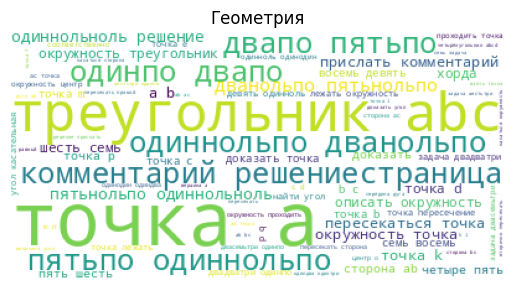

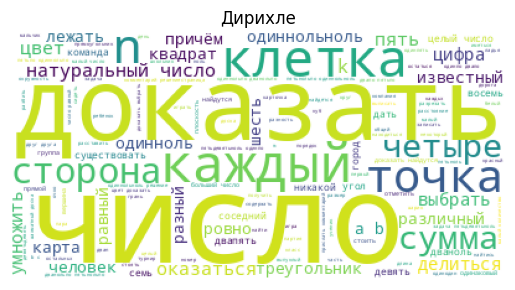

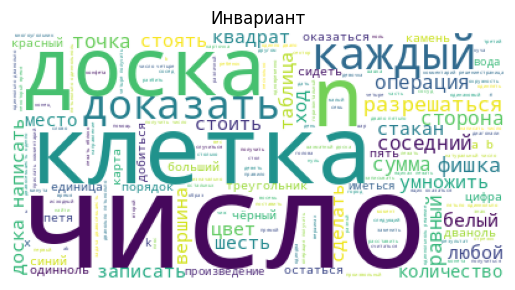

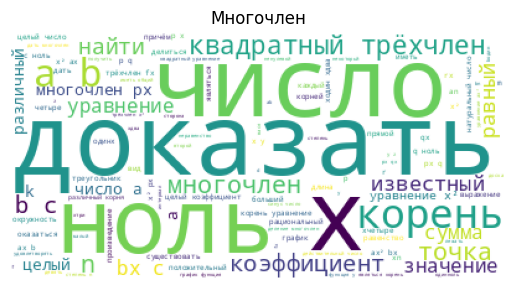

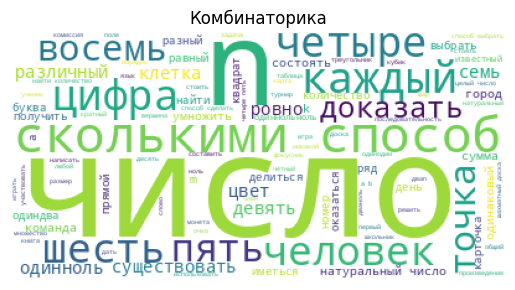

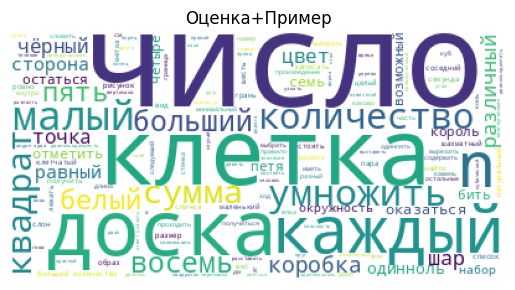

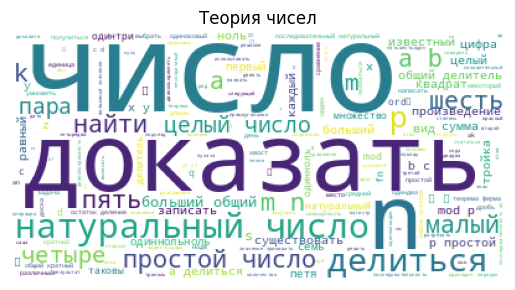

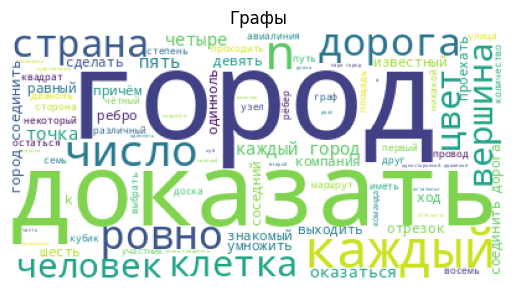

In [ ]:
# Анализируем ключевые слова по каждой теме
for topic in data.topic.unique():
    df = data[data.topic == topic]
    text = ' '.join(df['new_task'])
    text_tokens = word_tokenize(text)

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white').generate(' '.join(text_tokens))
    plt.imshow(cloud)
    plt.axis('off')
    plt.title(topic)
    plt.show()

**N-grams**

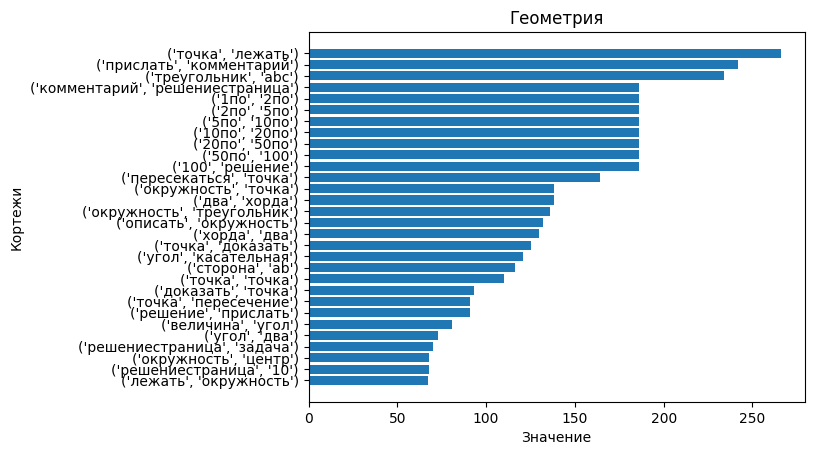

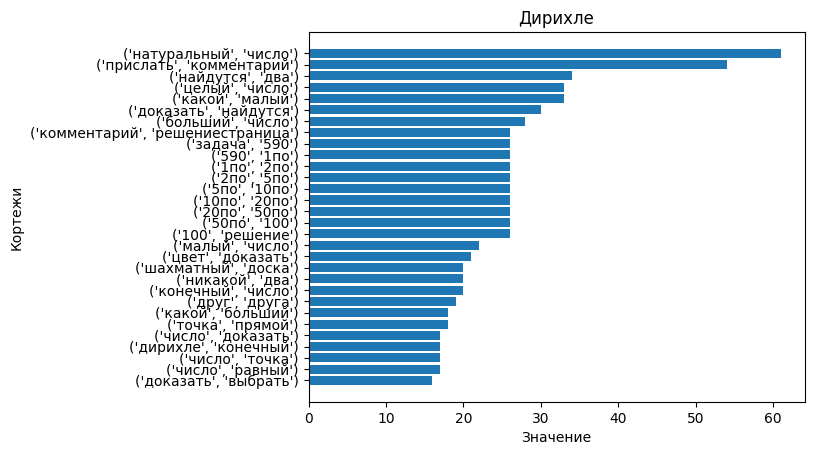

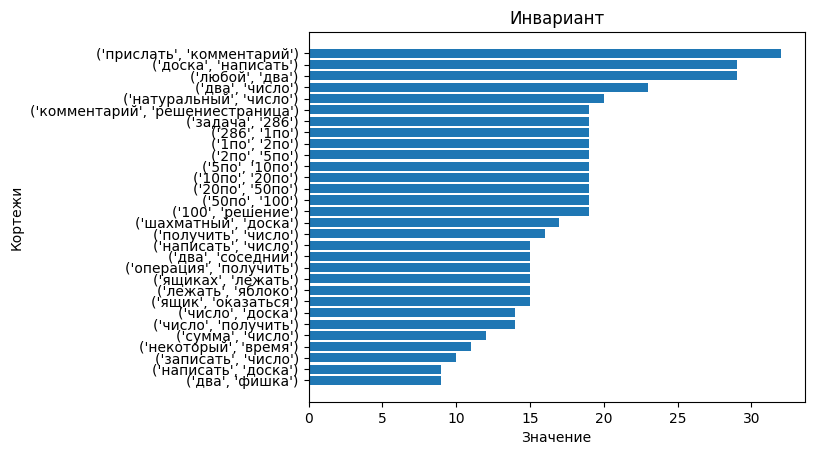

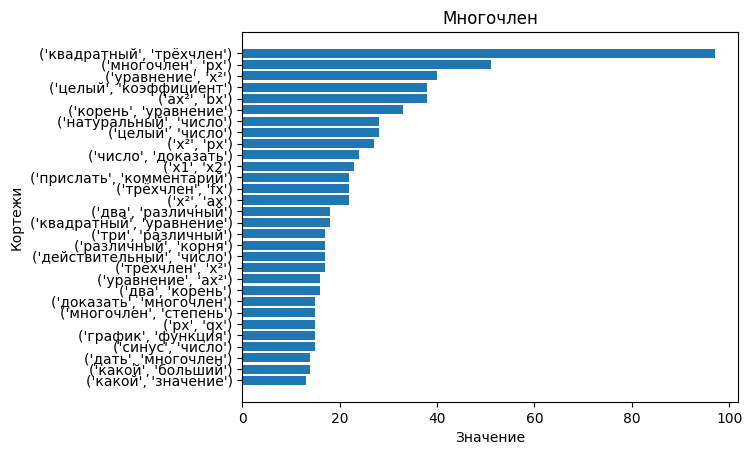

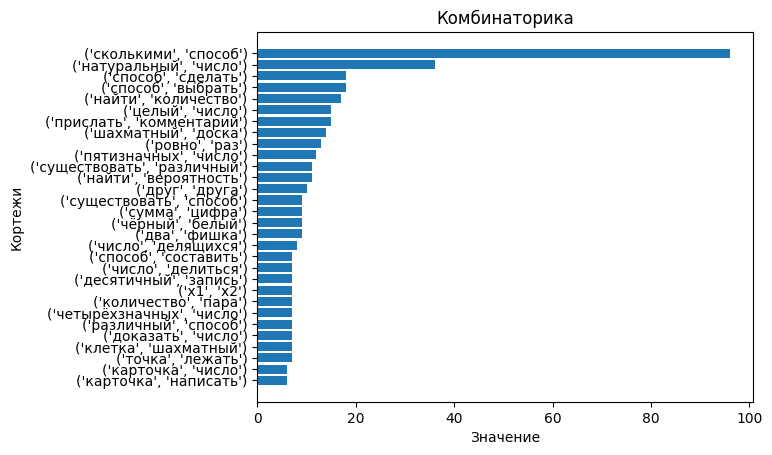

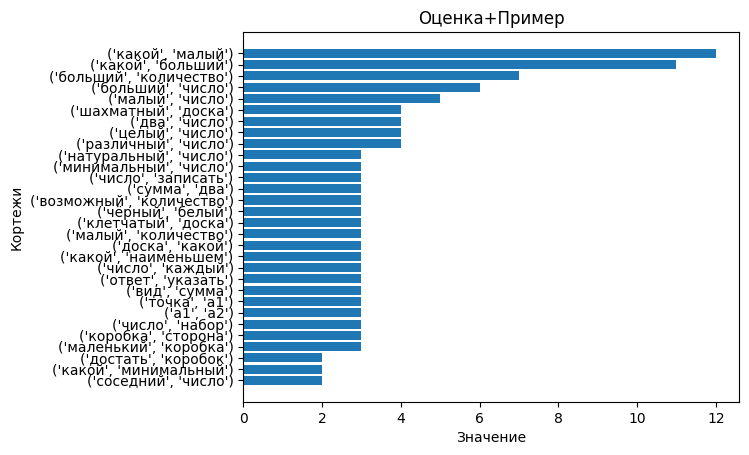

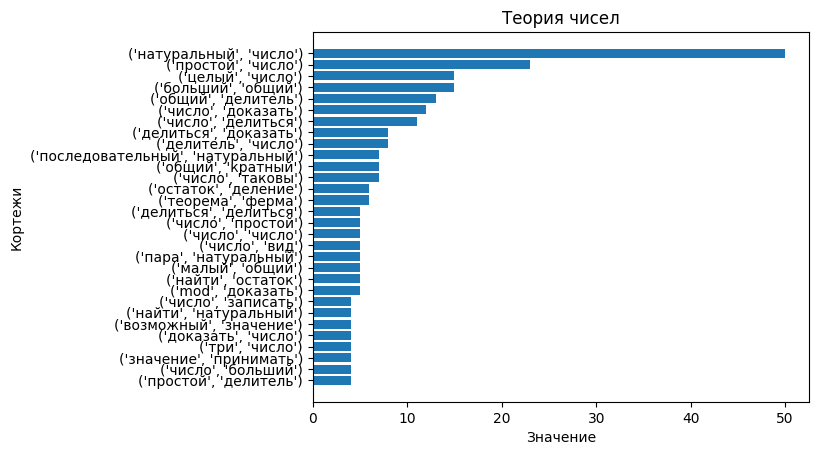

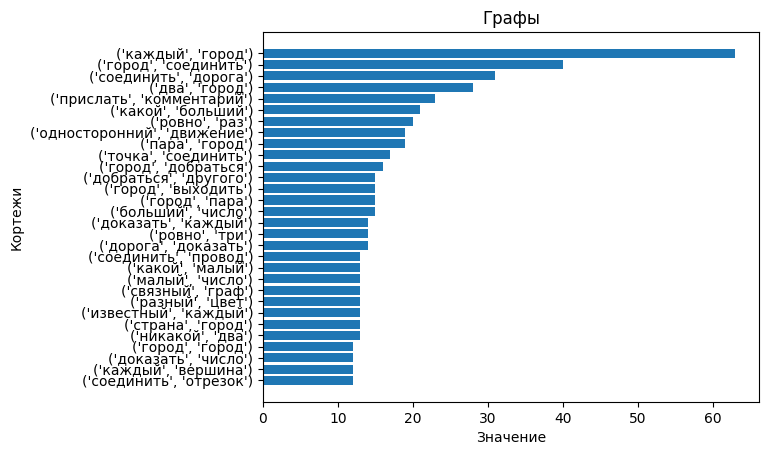

In [ ]:
k = 30
n = 2
for topic in data.topic.unique():
    df = data[data.topic == topic]
    words = ' '.join(df.new_task_pros)
    words = ' '.join(list(filter(lambda x: len(x) >= 2, (words.split()))))
    tokens = nltk.word_tokenize(words)

    ngrams_list = list(ngrams(tokens, n))
    freq_dist = dict(FreqDist(ngrams_list))
    sorted_data = sorted(freq_dist.items(), key=lambda x: -x[1])

    y_labels = [str(key) for key, _ in sorted_data][:k][::-1]
    x_values = [value for _, value in sorted_data][:k][::-1]

    plt.barh(y_labels, x_values)
    plt.xlabel('Значение')
    plt.ylabel('Кортежи')
    plt.title(topic)
    plt.show()

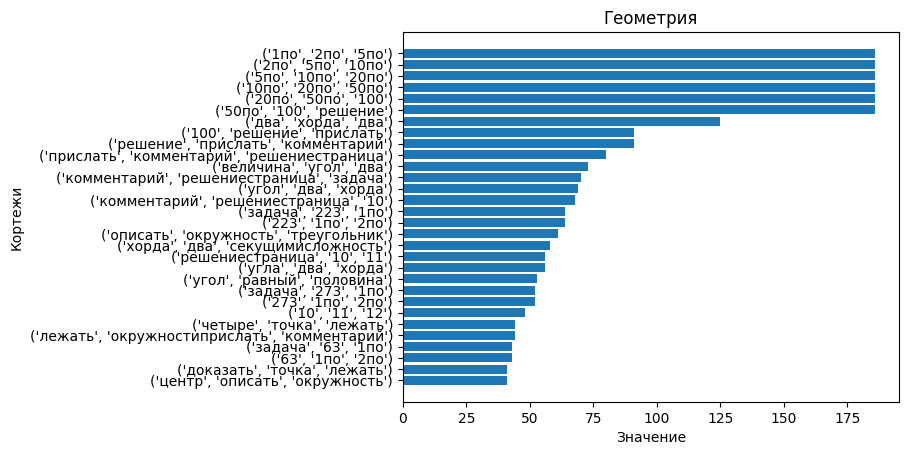

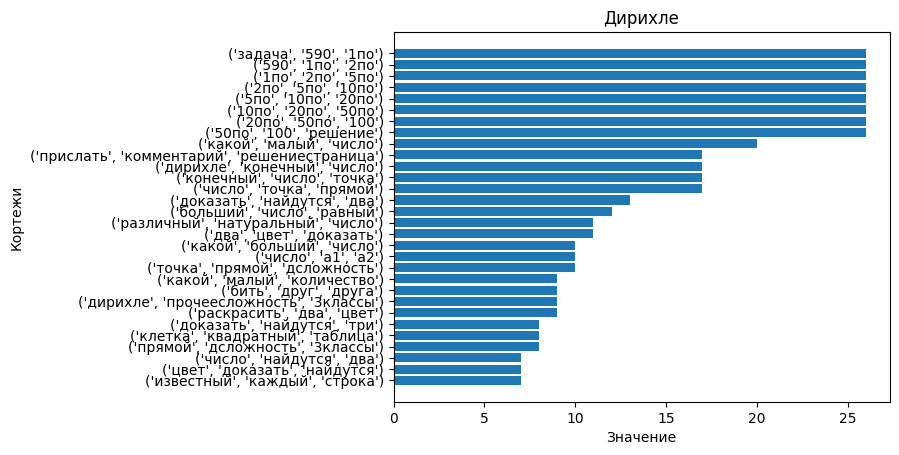

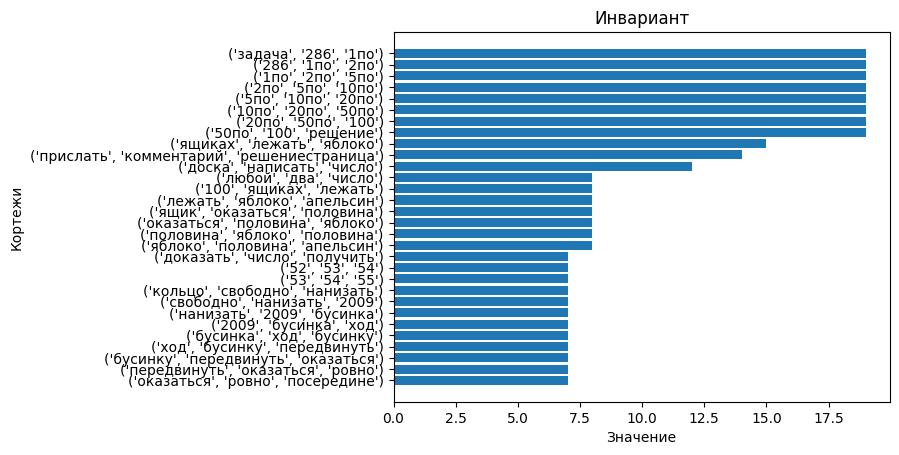

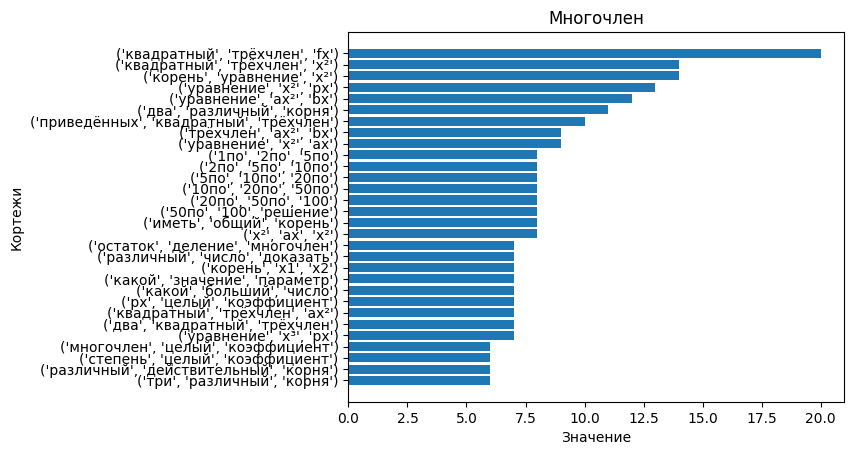

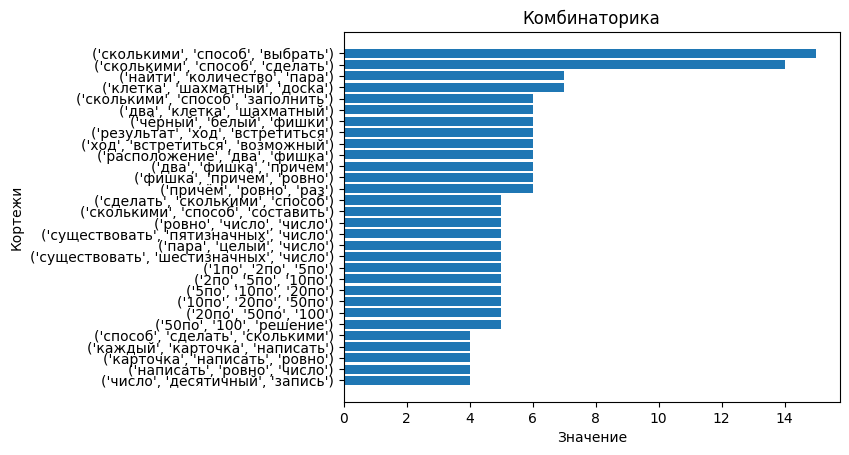

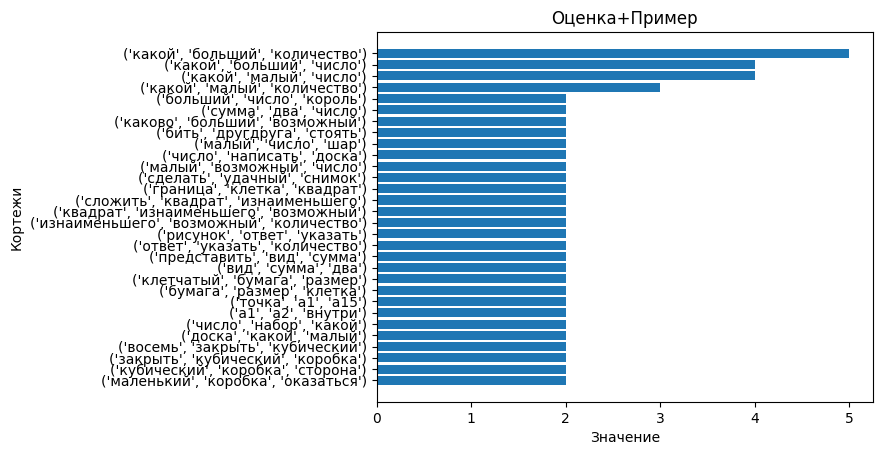

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119886 (\N{MATHEMATICAL ITALIC SMALL A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119909 (\N{MATHEMATICAL ITALIC SMALL X}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119887 (\N{MATHEMATICAL ITALIC SMALL B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 119910 (\N{MATHEMATICAL ITALIC SMALL Y}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


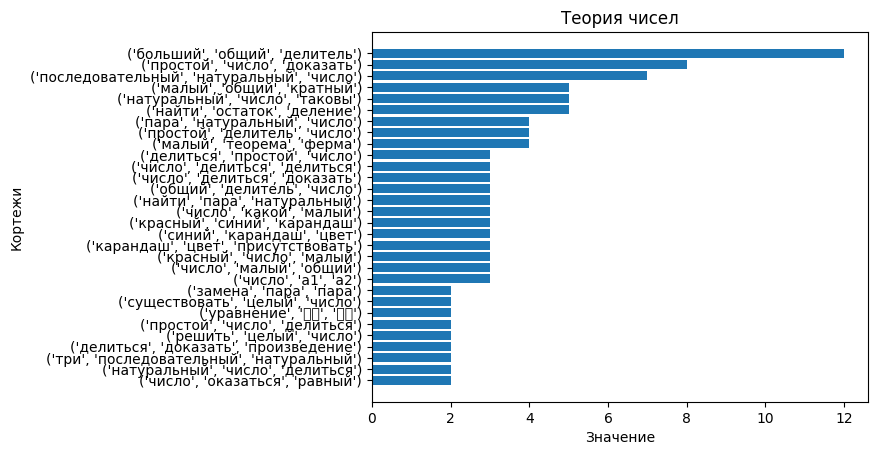

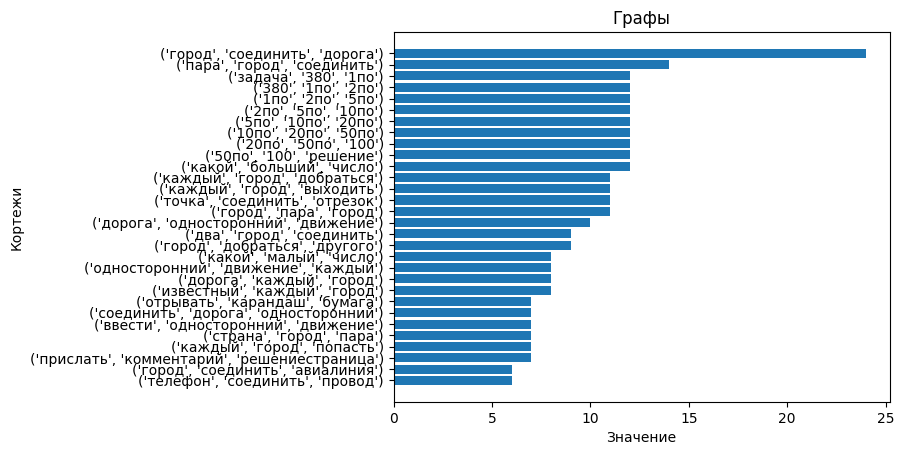

In [ ]:
k = 30
n = 3
for topic in data.topic.unique():
    df = data[data.topic == topic]
    words = ' '.join(df.new_task_pros)
    words = ' '.join(list(filter(lambda x: len(x) >= 2, (words.split()))))
    tokens = nltk.word_tokenize(words)

    ngrams_list = list(ngrams(tokens, n))
    freq_dist = dict(FreqDist(ngrams_list))
    sorted_data = sorted(freq_dist.items(), key=lambda x: -x[1])

    y_labels = [str(key) for key, _ in sorted_data][:k][::-1]
    x_values = [value for _, value in sorted_data][:k][::-1]

    plt.barh(y_labels, x_values)
    plt.xlabel('Значение')
    plt.ylabel('Кортежи')
    plt.title(topic)
    plt.show()

# Preprocessing

In [ ]:
topic_dict = dict()
for i, name in enumerate(data.topic.unique()):
  topic_dict[name] = i
print(topic_dict)

{'Геометрия': 0, 'Дирихле': 1, 'Инвариант': 2, 'Многочлен': 3, 'Комбинаторика': 4, 'Оценка+Пример': 5, 'Теория чисел': 6, 'Графы': 7}


In [ ]:
data['y'] = data.topic.apply(lambda topic: topic_dict[topic])

## Word2Vec

In [ ]:
def to_sentences(text):
    doc = nlp(text)
    return [sent.text for sent in doc.sents]

def txt_to_mas(text):
    return [elem for elem in text.split() \
            if ((len(elem) > 3) and
                len(set(list(ascii_letters) + list(map(str, range(10)))) & set(elem)) == 0)]

def keep_russian_words(text):
    new_text = ''
    for word in text.split():
      if len(set(ascii_letters) & set(word)) == 0:
             new_text += word + " "
    return new_text

def only_russian_words(text):
    pattern = re.compile(r'\b[а-яА-Я]+\b')
    russian_words = pattern.findall(text)
    result_text = ' '.join(russian_words)
    return result_text

def filter_text(text):
    text = del_garbage(text).lower()
    text = lemmatize_text(text)
    return text

def filter_sentences(mas: list):
    mas =  list(map(only_russian_words, mas))
    mas = list(filter(lambda x: len(x.split()) > 5, mas))
    mas = list(map(filter_text, mas))
    return mas

### Learn

In [ ]:
with open(path_to_folder + '/Dataset/978-5-7996-1779-0_2016.txt') as file: math_txt_1 = file.read()
with open(path_to_folder + '/Dataset/978-5-7996-1340-2_2014.txt') as file: math_txt_2 = file.read()

In [ ]:
task_filter = data.new_task.apply(lambda text: del_garbage(filters_dig(text).lower()))
math_text_first = del_garbage(keep_russian_words(" ".join(math_txt_1.split())))
math_text_second = del_garbage(keep_russian_words(" ".join(math_txt_2.split())))

# -
math_text_first_filter = filter_sentences(to_sentences(math_text_first))
math_text_second_filter = filter_sentences(to_sentences(math_text_second))

# -
math_1_ready = list(map(txt_to_mas, math_text_first_filter))
math_2_ready = list(map(txt_to_mas, math_text_second_filter))
task_filter = list(map(txt_to_mas, task_filter))

In [ ]:
learn_mas = math_1_ready.copy()
learn_mas.extend(math_2_ready)
learn_mas.extend(task_filter)
random.shuffle(learn_mas)

In [ ]:
%time model = w2v(sentences=learn_mas, min_count=0)

model.save("word2vec_math_text.model")

CPU times: user 2.55 s, sys: 11.9 ms, total: 2.56 s
Wall time: 2.54 s


In [ ]:
model.wv.most_similar('математика', topn=5)

[('наука', 0.9981386661529541),
 ('сегодня', 0.9981216192245483),
 ('переливание', 0.9979371428489685),
 ('магазин', 0.9976463913917542),
 ('независимо', 0.9975666999816895)]

### ADD Feature

In [ ]:
model = w2v.load(path_to_folder + '/word2vec_math_text.model')

In [ ]:
for i in range(100):
  data[f'vector_{i}'] = 0

for j, text in enumerate(data['new_task']):
  vec = np.zeros(100)
  lens = 0
  for word in word_tokenize(text):
      try:
        vec += model.wv[word]
        lens += 1
      except KeyError:
        continue

  vec /= lens
  for i in range(100):
    data.iloc[j, data.shape[1]-100+i] = vec[i]

### Visualization

In [ ]:
y, x, = data.iloc[:, 3], data.iloc[:, 4:]

In [ ]:
x.fillna(0, inplace=True)

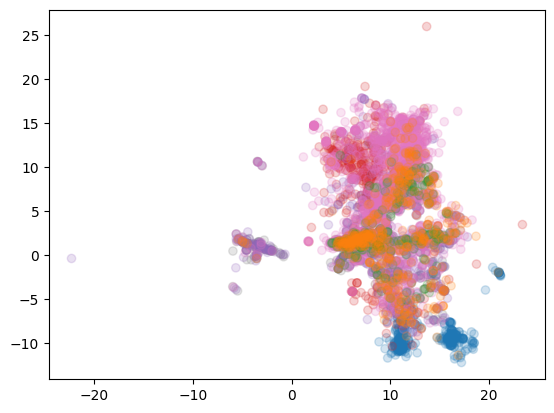

In [ ]:
mapper_w2v = umap.UMAP(densmap=True).fit_transform(x)
plt.scatter(
    mapper_w2v[:, 0],
    mapper_w2v[:, 1],
    c=[sns.color_palette()[x] for x in y],
    alpha=0.2)

In [ ]:
print([i for i in topic_dict], sep='')
sns.color_palette()

['Геометрия', 'Дирихле', 'Инвариант', 'Многочлен', 'Комбинаторика', 'Оценка+Пример', 'Теория чисел', 'Графы']


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## TF-IDF

In [ ]:
def txt_to_txt(text):
    mas = txt_to_mas(text)
    return " ".join(mas)

In [ ]:
def vect_tfidf(text):
  return vectorizer.transform([text]).toarray()

### Learn

In [ ]:
learn_tf_idf = list(data.new_task.apply(lambda text: del_garbage(filters_dig(text).lower())))
learn_tf_idf = list(map(txt_to_txt, learn_tf_idf))
learn_tf_idf.extend(txt_to_txt(" ".join(math_text_first_filter)).split())
learn_tf_idf.extend(txt_to_txt(" ".join(math_text_second_filter)).split())

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, min_df=3)
X = vectorizer.fit_transform(learn_tf_idf)

In [ ]:
with open('vectorizer.pickle', 'wb') as fin: pickle.dump(vectorizer, fin)

### Loading

In [ ]:
with open(path_to_folder + '/vectorizer.pickle', 'rb') as fin: vectorizer = pickle.load(fin)

In [ ]:
train_title_tfidf = np.vstack(data["new_task"].apply(vect_tfidf))

In [ ]:
for i in tqdm(range(len(vectorizer.get_feature_names_out()))):
  data[f"Tiidf title f.{i + 1}"] = train_title_tfidf[:, i]

100%|██████████| 3948/3948 [00:04<00:00, 929.81it/s]


## Yargy-парсер

In [ ]:
topic_name = []
topic_one_to_one = []
Case = fact('Case', ['name'])

def make_topic(topic: list, name: str):
    global topic_name

    topic_name.append(morph_pipeline(topic).interpretation(
          Case.name.const(name)
      ).interpretation(
          Case
      )
    )

def make_topic_one_to_one(topic: list):
    global topic_name

    return morph_pipeline(topic).interpretation(
          Case.name.normalized()
      ).interpretation(
          Case
      )

top_topic = [
    (["окружность", "угол", "докажите", "треугольник","пересекаться", "сторона","центр",
      "точка", "параллельность", "хорда", "вершина", "высоты", "пересечение", "прямая"], 'Геометрия'),

    (["деление", "множители", "корень", "квадратный трехчлен", "неизвестная","многочлен", "функция",
      "уравнение", "коэффициент ", "кубический многочлен", "равенство","неравенство", "член"], 'Многочлен'),

    (["клетка", "закрасить", "доска", "фишка", "сумма", "выбрать", "делиться", "известный"], 'Дирихле'),

    (["делится", "оканчивается", "подряд", "НОД", "НОК", "наименьшего общего кратного", "простой", "большой", "общий", 'Натуральный число',
      'Произведение', 'Степень', 'Умножение', 'Вычитание', "Сложение", "число", "цифра"], 'Теория чисел'),

    (["способ", "разделить", "составить", "расставить","существовать","различный",
      "порядок", "буква", "ровно", "получить", "состоять" ], 'Комбинаторика'),

    (["последовательность", "разрешаться", "равный", "соседний", "стакан", "таблица", "стоить", "операция"], 'Инвариант'),

    (["сумма", "каждый", "коробка", "малый", "белый","больший", "набор", "бить", "отметить",
      "больший количество", "больший число", "шахматный доска"], 'Оценка+Пример'),

    (['город', "ребро", "компания", "каждый город","страна", "проехать", "знакомый", "соединить"], 'Графы')
]

for name_complaint in top_topic:
    make_topic(name_complaint[0], name_complaint[1])
    topic_one_to_one.extend(list(name_complaint[0]))
    for columns in list(name_complaint[0]):
      data[columns] = np.NaN

OTHERS = make_topic_one_to_one(topic_one_to_one)

ALL = or_(*topic_name).interpretation(Case)
OTHERS_ALL = or_(OTHERS).interpretation(Case)

In [ ]:
%%time
parser = Parser(OTHERS_ALL)
for ind, elem in enumerate(data['task']):
    for match in parser.findall(str(elem)):
        data.loc[ind, match.fact.name] = 1

parser = Parser(ALL)
for ind, elem in enumerate(data['task']):
    for match in parser.findall(str(elem)):
        data.loc[ind, match.fact.name] = 1

CPU times: user 4min 14s, sys: 1.46 s, total: 4min 16s
Wall time: 4min 18s


## Tenserflow token

In [ ]:
vocab_size = 20000
trunc_type = 'post'
padding_type = 'post'
embedding_dim = 128
max_length = 120
oov_tok = '<OOV>'


### Learn

In [ ]:
text = data['new_task']
labels = data['y']
tokenizer = Tokenizer(
    num_words=vocab_size,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    oov_token=oov_tok
)

tokenizer.fit_on_texts(text)
train_sequences = tokenizer.texts_to_sequences(text)
train_padded = pad_sequences(
    train_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)
with open('tokenizer.pickle', 'wb') as fin: pickle.dump(tokenizer, fin)

### ADD Feature

In [ ]:
with open(path_to_folder + '/tokenizer.pickle', 'rb') as fin: tokenizer = pickle.load(fin)
train_sequences = tokenizer.texts_to_sequences(data.new_task)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
for i in tqdm(range(max_length)):
    data[f"Tokens f.{i + 1}"] = train_padded[:, i]

100%|██████████| 120/120 [00:00<00:00, 786.37it/s]


# Аnalysis

In [ ]:
sns.set_style("whitegrid")
sns.set(rc={'axes.facecolor':'#EBEBEB', 'figure.figsize': (11.7, 8.27)})

<Axes: xlabel='topic', ylabel='Count'>

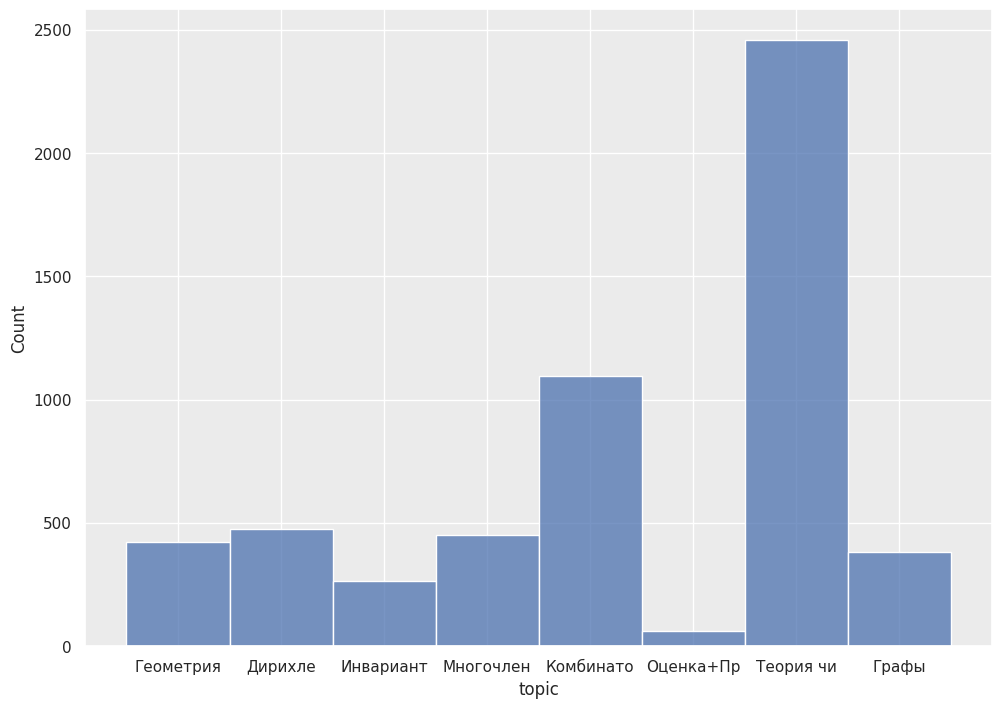

In [ ]:
sns.histplot(x=data['topic'].apply(lambda x: x[:9]))

In [ ]:
data.fillna(0)

In [ ]:
data.groupby('Геометрия').agg('sum').set_index(pd.Index(['sums'])) #.sort_values(by=['sums'], ascending=False)

,y,окружность,угол,докажите,треугольник,пересекаться,сторона,центр,точка,параллельность,...,набор,бить,отметить,чёрный,Многочлен,Комбинаторика,Дирихле,Теория чисел,Оценка+Пример,Инвариант
sums,11927,443.0,311.0,2397.0,437.0,228.0,539.0,219.0,727.0,0.0,...,46.0,21.0,116.0,58.0,482.0,860.0,2043.0,890.0,428.0,573.0


In [ ]:
data.topic.unique()

array(['Геометрия', 'Дирихле', 'Инвариант', 'Многочлен', 'Комбинаторика',
       'Оценка+Пример', 'Теория чисел', 'Графы'], dtype=object)

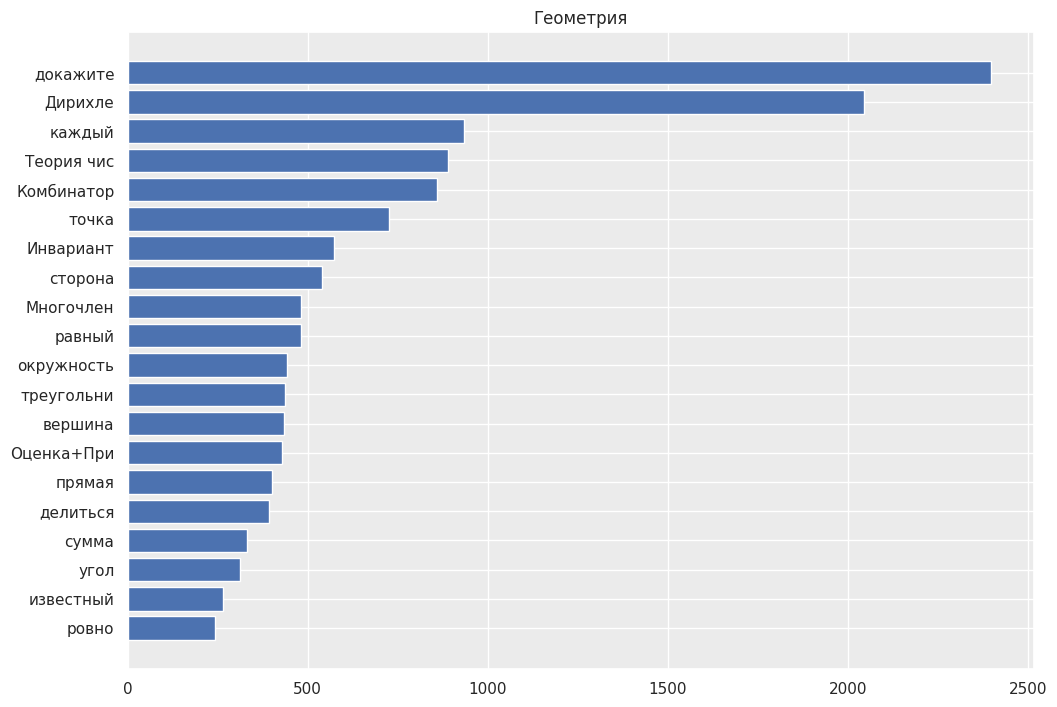

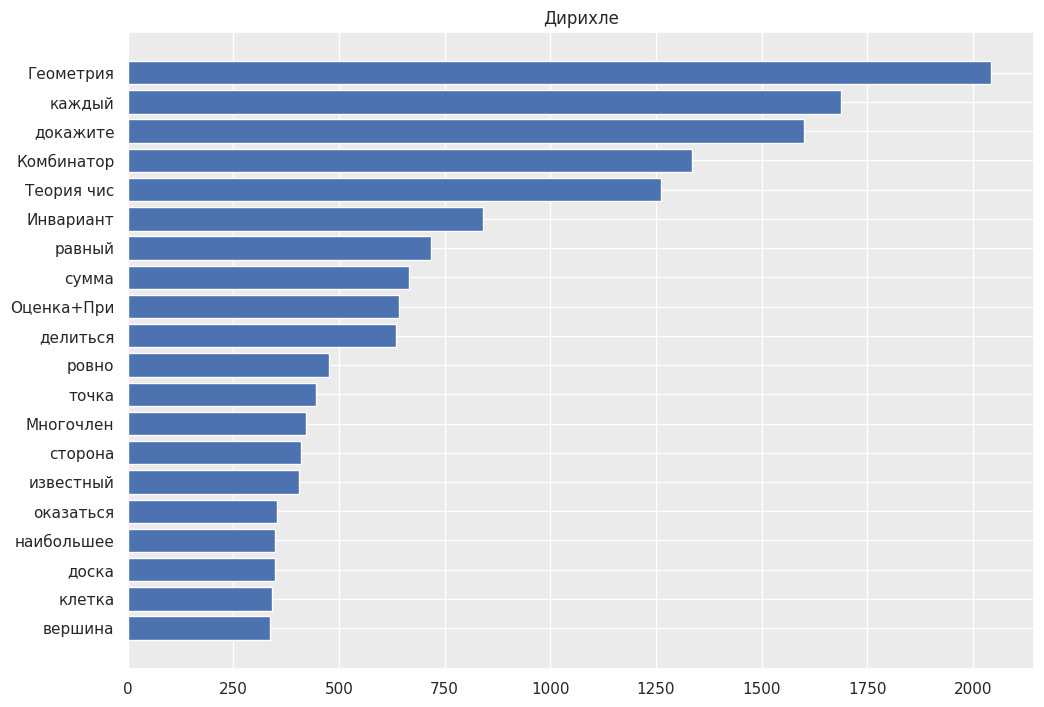

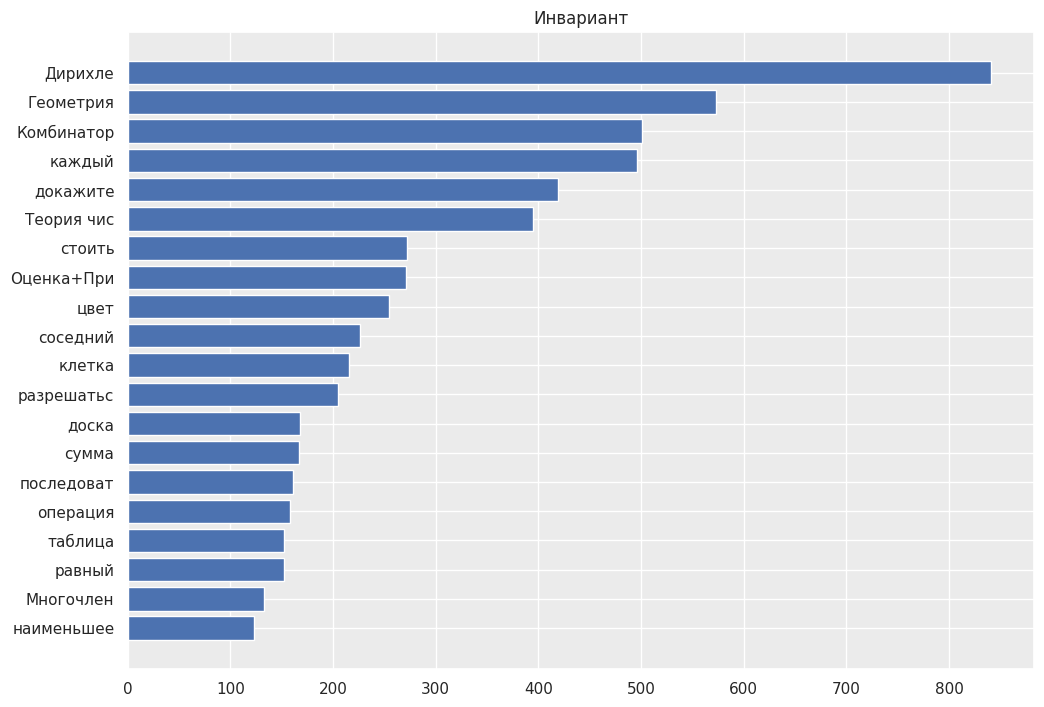

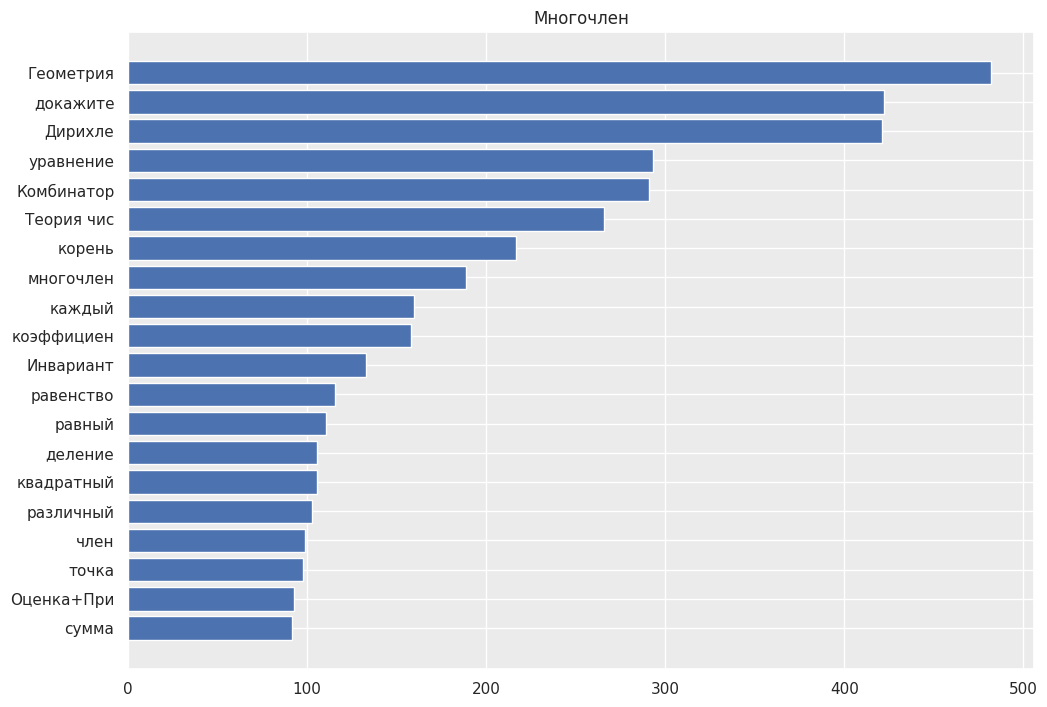

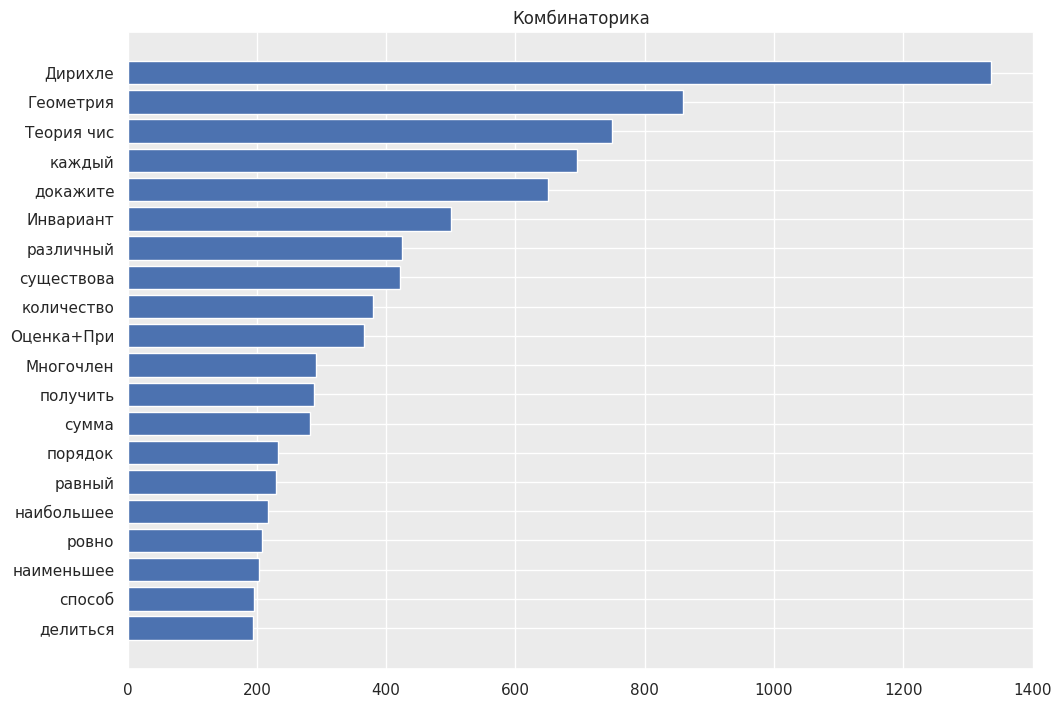

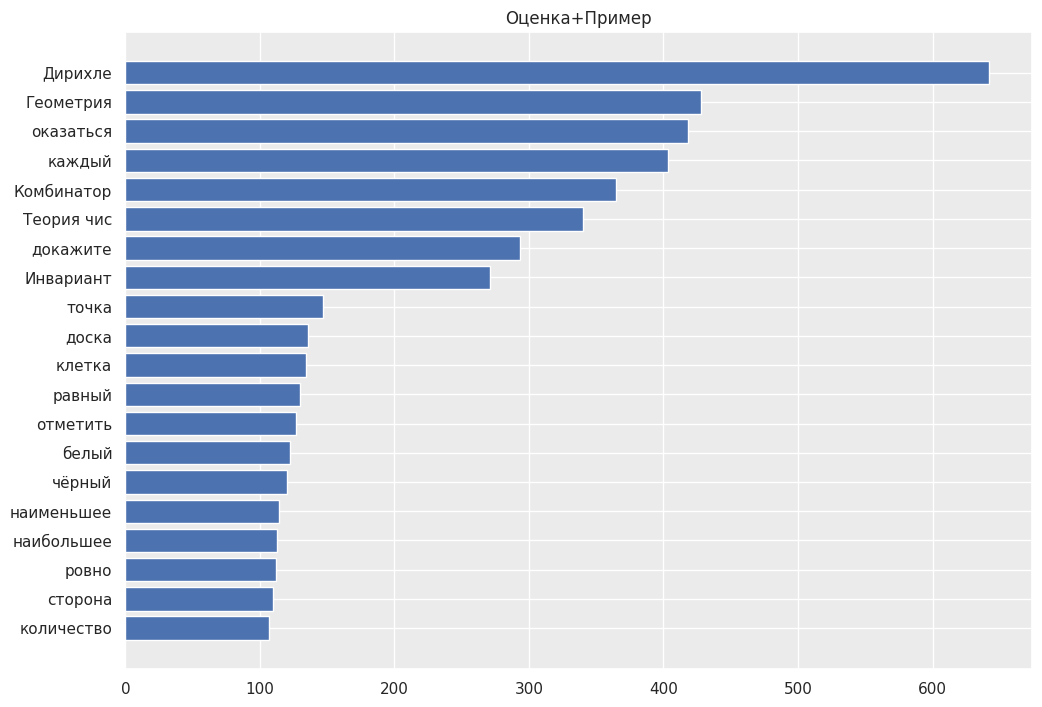

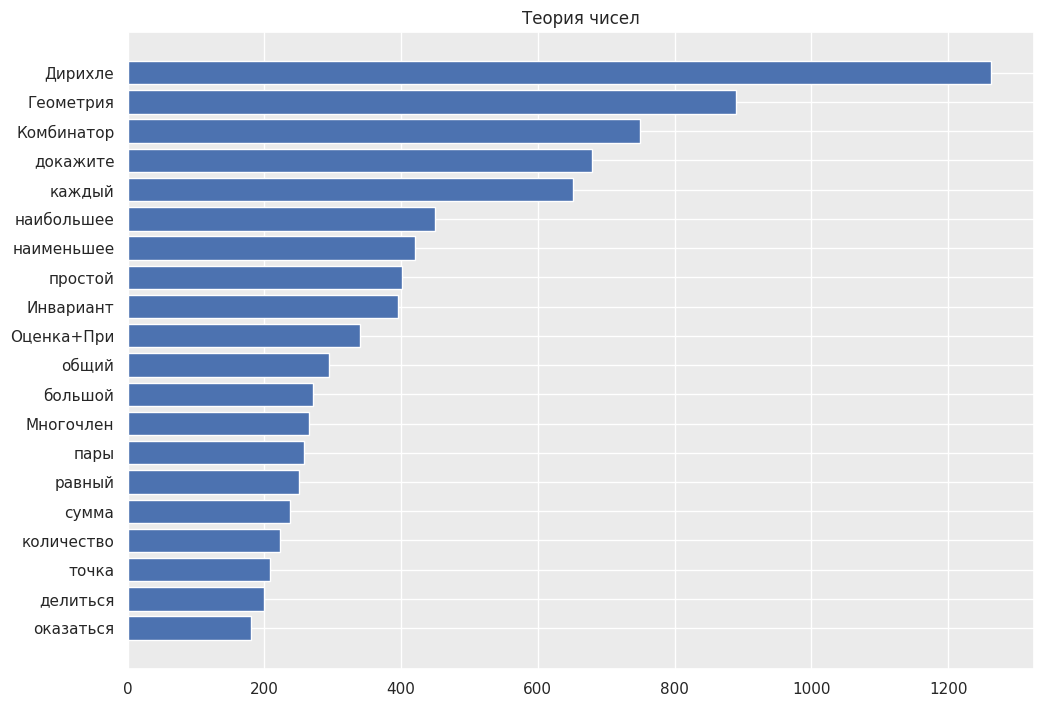

Графы не добавили в yargy-парсер


In [ ]:
for topic in data.topic.unique():
    try:
        df = data.groupby(topic)\
            .agg('sum')\
            .set_index(pd.Index(['sums']))
        elements_to_check = ['Tokens', 'vector_', 'Tiidf', 'y']
        df.head()
        df = df[[i for i in df.columns if all(element not in i for element in elements_to_check)]]
        df = df.T.sort_values(by=['sums'], ascending=False)
        x, y = list(map(lambda x: x[:10], df.index[:20])), df.sums[:20]
        plt.barh(x[::-1], y[::-1])
        plt.title(topic)
        plt.show()
    except KeyError:
      print(f"{topic} не добавили в yargy-парсер")

# ML

In [ ]:
def visualization_feature_importances(model, data, k=20):

    feature_importance = model.feature_importances_
    feature_names = [x for x in data.columns if x != 'y']

    sorted_idx = np.argsort(feature_importance)[-k:]
    plt.figure(figsize=(16, 12))

    plt.barh(range(k),
             feature_importance[sorted_idx],
             align='center')

    plt.yticks(range(k),
              [feature_names[i] for i in sorted_idx],
               fontsize=7)

    plt.xlabel('Важность факторов')
    plt.ylabel('Факторы')
    plt.title('График важности факторов')

    plt.show()

    return [feature_names[i] for i in sorted_idx][::-1]

In [ ]:
data_learn = data.drop(columns=['new_task', 'task'])
data_learn.fillna(0, inplace=True)

# -

df_shuffled = data_learn.sample(frac=1, random_state=42).reset_index(drop=True)
df_shuffled.drop(columns=['topic'], inplace=True)
try:
  df_shuffled.drop(columns=[None], inplace=True)
except KeyError as err:
  print(err)
# -

x, y = df_shuffled[[column for column in df_shuffled.columns if column != 'y']], df_shuffled['y']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

'[None] not found in axis'


In [ ]:
def get_metric(model, x_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(report)

## Base

In [ ]:
model_boost = GradientBoostingClassifier(max_depth=3).fit(X_train, y_train)

In [ ]:
get_metric(model_boost, X_test, y_test)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92       105
           1       0.47      0.22      0.30       107
           2       0.52      0.24      0.33        67
           3       0.81      0.70      0.75       129
           4       0.42      0.35      0.38       283
           5       0.20      0.07      0.10        15
           6       0.66      0.84      0.74       601
           7       0.09      0.09      0.09        97

    accuracy                           0.60      1404
   macro avg       0.51      0.43      0.45      1404
weighted avg       0.58      0.60      0.58      1404



In [ ]:
with open('Boosting.pickle', 'wb') as f:
      pickle.dump(model_boost, f)

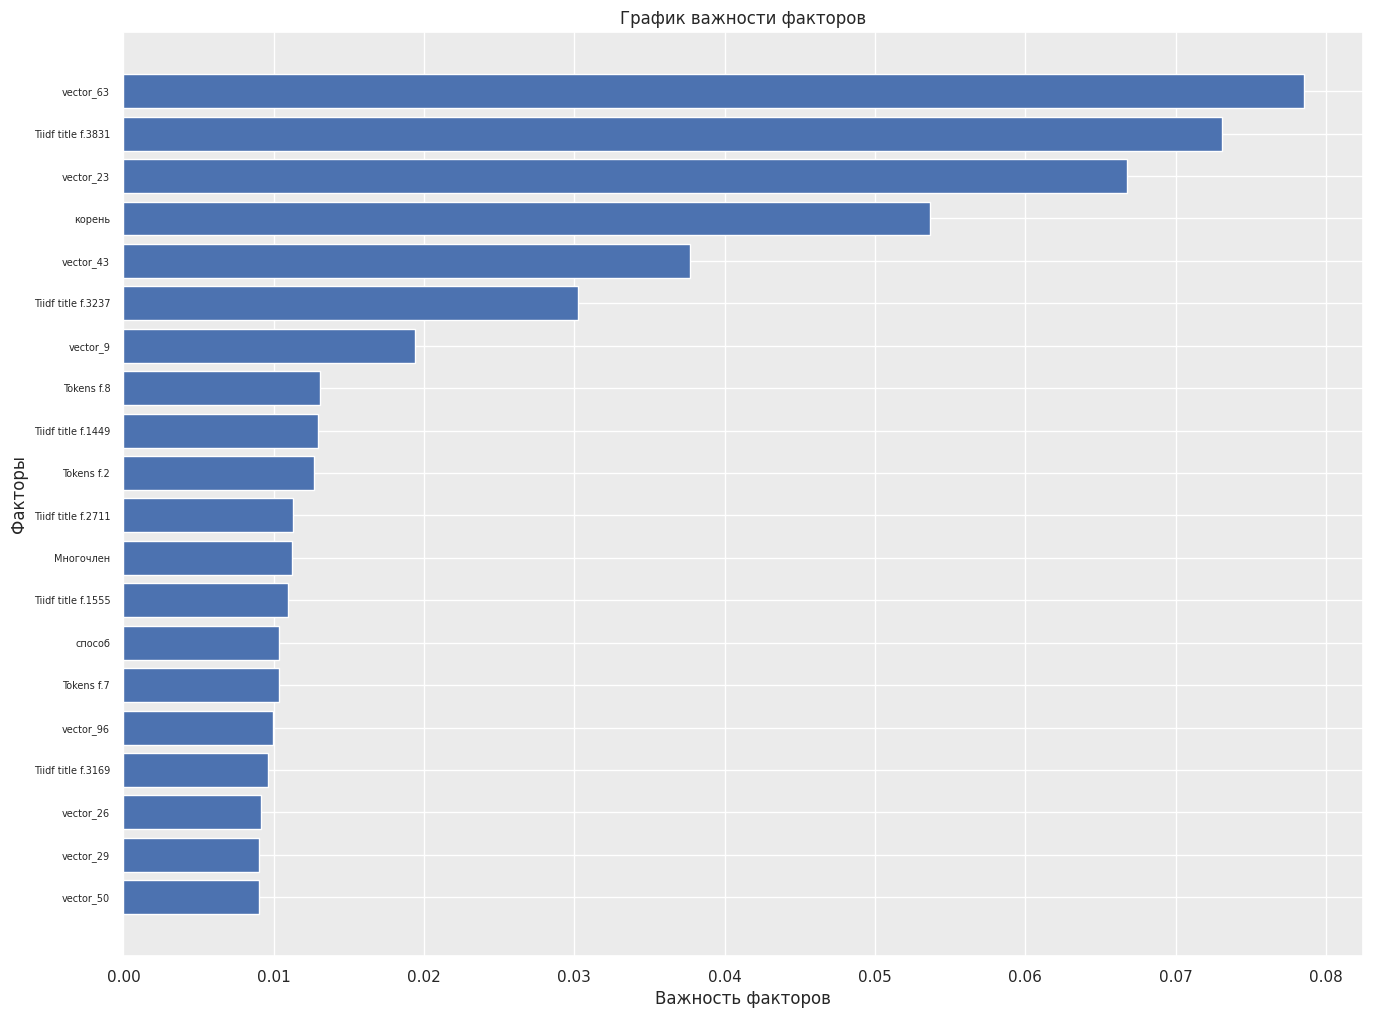

['vector_63',
 'Tiidf title f.3831',
 'vector_23',
 'корень',
 'vector_43',
 'Tiidf title f.3237',
 'vector_9',
 'Tokens f.8',
 'Tiidf title f.1449',
 'Tokens f.2',
 'Tiidf title f.2711',
 'Многочлен',
 'Tiidf title f.1555',
 'способ',
 'Tokens f.7',
 'vector_96',
 'Tiidf title f.3169',
 'vector_26',
 'vector_29',
 'vector_50']

In [ ]:
visualization_feature_importances(model_boost, X_train, k=20)

## Select

### Models

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [ ]:
models = {'Ridger': RidgeClassifier(), 'LogisticRegression': LogisticRegression(),
          'SGDr': SGDClassifier(), 'SVC': SVC(), "KNN": KNeighborsClassifier(n_neighbors=3),
          "RandomForest":RandomForestClassifier(), 'XGB': XGBClassifier(),
          'CatBoost': CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1,
                                         loss_function='MultiClass', custom_metric=['F1'], verbose=False)}

In [ ]:
for model in models:
    print('-'*84)
    print(model)
    models[model].fit(X_train, y_train)
    print(f1_score(y_test, models[model].predict(X_test), average='weighted'))

------------------------------------------------------------------------------------
Ridger
0.5794515833444751
------------------------------------------------------------------------------------
LogisticRegression
0.30304208808060085
------------------------------------------------------------------------------------
SGDr
0.2761537163780171
------------------------------------------------------------------------------------
SVC
0.29317284706320956
------------------------------------------------------------------------------------
KNN
0.2976380166086201
------------------------------------------------------------------------------------
RandomForest
0.49577670671295415
------------------------------------------------------------------------------------
XGB
0.5615348362445912
------------------------------------------------------------------------------------
CatBoost
0.5414409324338195


In [ ]:
estimators = [
     ('Ridge', RidgeClassifier()),
     ('lg', LogisticRegression()),
     ('svc', SVC()),
     ('rf', RandomForestClassifier()),
     ('xgb', XGBClassifier()),
     ('ctb', CatBoostClassifier())
]
clf = StackingClassifier(
     estimators=estimators, final_estimator=XGBClassifier()
)
clf.fit(X_train, y_train).score(X_test, y_test)

0.7250712250712251

In [ ]:
get_metric(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       105
           1       0.59      0.37      0.46       107
           2       0.79      0.33      0.46        67
           3       0.79      0.73      0.76       129
           4       0.70      0.63      0.66       283
           5       0.36      0.27      0.31        15
           6       0.71      0.85      0.78       601
           7       0.70      0.70      0.70        97

    accuracy                           0.73      1404
   macro avg       0.70      0.60      0.63      1404
weighted avg       0.72      0.73      0.71      1404



### Выбор выборки

In [ ]:
#X_train, X_test, y_train, y_test

In [ ]:
one, two, three, four = X_train.iloc[:, :100], X_train.iloc[:, 100:100+3948], \
                        X_train.iloc[:, 100+3948:4146], X_train.iloc[:, 4146:]
ones, twos, threes, fours = X_test.iloc[:, :100], X_test.iloc[:, 100:100+3948], \
                            X_test.iloc[:, 100+3948:4146], X_test.iloc[:, 4146:]
samples_train = [one, two, three, four]
samples_test = [ones, twos, threes, fours]

In [ ]:
for model in models:
    print('-'*84)
    print(model)
    for ind, x_train, x_test in zip(range(1, 5), samples_train, samples_test):
        print(f'Выборка: {ind}')
        models[model].fit(x_train, y_train)
        print('   ', f1_score(y_test, models[model].predict(x_test), average='weighted'))

------------------------------------------------------------------------------------
Ridger
Выборка: 1
0.4955071968818963
Выборка: 2
0.5836209059181345
Выборка: 3
0.545753418884024
Выборка: 4
0.27026173157998
------------------------------------------------------------------------------------
LogisticRegression
Выборка: 1
0.5117608788675935
Выборка: 2
0.5815469226859269
Выборка: 3
0.5660901595394798
Выборка: 4
0.30518056781217934
------------------------------------------------------------------------------------
SGDr
Выборка: 1
0.509541116725752
Выборка: 2
0.5746254049075065
Выборка: 3
0.5153711337767717
Выборка: 4
0.23740966411363634
------------------------------------------------------------------------------------
SVC
Выборка: 1
0.4197440783217217
Выборка: 2
0.5630049626906081
Выборка: 3
0.5473115564930342
Выборка: 4
0.29181358921142003
------------------------------------------------------------------------------------
KNN
Выборка: 1
0.4555317704496633
Выборка: 2
0.45769498825648

In [ ]:
train = two.copy(deep=True)
for name in three.columns:
    train[name] = three[name]

test = twos.copy(deep=True)
for name in threes.columns:
    test[name] = threes[name]

In [ ]:
for model in models:
    print('-'*84)
    print(model)
    models[model].fit(train, y_train)
    print(f1_score(y_test, models[model].predict(test), average='weighted'))

------------------------------------------------------------------------------------
Ridger
0.5888354619850728
------------------------------------------------------------------------------------
LogisticRegression
0.5913016708059279
------------------------------------------------------------------------------------
SGDr
0.5786758167943729
------------------------------------------------------------------------------------
SVC
0.5498858340014139
------------------------------------------------------------------------------------
KNN
0.5109396742317169
------------------------------------------------------------------------------------
RandomForest
0.5232300738399371
------------------------------------------------------------------------------------
XGB
0.5626232296958422
------------------------------------------------------------------------------------
CatBoost
0.5507124296748808


In [ ]:
for model in models:
    print('-'*84)
    print(model)
    models[model].fit(X_train.iloc[:, :4146], y_train)
    print(f1_score(y_test, models[model].predict(X_test.iloc[:, :4146]), average='weighted'))

------------------------------------------------------------------------------------
Ridger
0.5884879738183355
------------------------------------------------------------------------------------
LogisticRegression
0.5973962040982905
------------------------------------------------------------------------------------
SGDr
0.5871075288368717
------------------------------------------------------------------------------------
SVC
0.5223765882709107
------------------------------------------------------------------------------------
KNN
0.5071598070803187
------------------------------------------------------------------------------------
RandomForest
0.48426364029673696
------------------------------------------------------------------------------------
XGB
0.5457030170059343
------------------------------------------------------------------------------------
CatBoost
0.5440687516110401


### Баланс выборки

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 1866), (1, 1866), (2, 1866), (3, 1866), (4, 1866), (5, 1866), (6, 1866), (7, 1866)]


In [ ]:
for model in models:
    print('-'*84)
    print(model)
    models[model].fit(X_resampled.iloc[:, :4146], y_resampled)
    print(f1_score(y_test, models[model].predict(X_test.iloc[:, :4146]), average='weighted'))

------------------------------------------------------------------------------------
Ridger
0.5739956809870226
------------------------------------------------------------------------------------
LogisticRegression
0.5705678419823954
------------------------------------------------------------------------------------
SGDr
0.5859973117672109
------------------------------------------------------------------------------------
SVC


KeyboardInterrupt: ignored

### Подбор гиперпараметров

In [ ]:
!pip install optuna

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

k = 10
X = x.iloc[:, :4146]
# LogisticRegression
def optimize_logistic_regression(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)

    model = LogisticRegression(C=C)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='weighted')
    score = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer).mean()

    return score

logreg_study = optuna.create_study(direction='maximize')
logreg_study.optimize(optimize_logistic_regression, n_trials=k)

logreg_best_params = logreg_study.best_params
logreg_best_score = logreg_study.best_value

# Вывод результатов
print("Logistic Regression Best Parameters:", logreg_best_params)
print("Logistic Regression Best F1 Score:", logreg_best_score)

# SGDClassifier
def optimize_sgd_classifier(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e-1)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    model = SGDClassifier(alpha=alpha, penalty=penalty)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='weighted')
    score = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer).mean()

    return score

sgd_study = optuna.create_study(direction='maximize')
sgd_study.optimize(optimize_sgd_classifier, n_trials=k)

sgd_best_params = sgd_study.best_params
sgd_best_score = sgd_study.best_value

# Вывод результатов
print("SGDClassifier Best Parameters:", sgd_best_params)
print("SGDClassifier Best F1 Score:", sgd_best_score)

# SVC
def optimize_svc(trial):
    C = trial.suggest_loguniform('C', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])

    model = SVC(C=C, kernel=kernel)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='weighted')
    score = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer).mean()

    return score

svc_study = optuna.create_study(direction='maximize')
svc_study.optimize(optimize_svc, n_trials=k)

svc_best_params = svc_study.best_params
svc_best_score = svc_study.best_value

# Вывод результатов
print("SVC Best Parameters:", svc_best_params)
print("SVC Best F1 Score:", svc_best_score)

# KNeighborsClassifier
def optimize_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 3, 10)

    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='weighted')
    score = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer).mean()

    return score

knn_study = optuna.create_study(direction='maximize')
knn_study.optimize(optimize_knn, n_trials=k)

knn_best_params = knn_study.best_params
knn_best_score = knn_study.best_value

# Вывод результатов
print("KNeighborsClassifier Best Parameters:", knn_best_params)
print("KNeighborsClassifier Best F1 Score:", knn_best_score)

# RandomForestClassifier
def optimize_random_forest(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_categorical('max_depth', [None, 10, 20, 30])

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='weighted')
    score = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer).mean()

    return score

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(optimize_random_forest, n_trials=k)

rf_best_params = rf_study.best_params
rf_best_score = rf_study.best_value

# Вывод результатов
print("RandomForestClassifier Best Parameters:", rf_best_params)
print("RandomForestClassifier Best F1 Score:", rf_best_score)

# XGBClassifier
def optimize_xgb(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)

    model = XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='weighted')
    score = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer).mean()

    return score

xgb_study = optuna.create_study(direction='maximize')
xgb_study.optimize(optimize_xgb, n_trials=k)

xgb_best_params = xgb_study.best_params
xgb_best_score = xgb_study.best_value

# Вывод результатов
print("XGBClassifier Best Parameters:", xgb_best_params)
print("XGBClassifier Best F1 Score:", xgb_best_score)

# CatBoostClassifier
def optimize_catboost(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 1e-1)
    depth = trial.suggest_int('depth', 4, 8)

    model = CatBoostClassifier(iterations=100, learning_rate=learning_rate, depth=depth,
                               loss_function='MultiClass', custom_metric=['F1'], verbose=False)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scorer = make_scorer(f1_score, average='weighted')
    score = cross_val_score(model, X, y, cv=skf, scoring=f1_scorer).mean()

    return score

catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(optimize_catboost, n_trials=k)

catboost_best_params = catboost_study.best_params
catboost_best_score = catboost_study.best_value

# Вывод результатов
print("CatBoostClassifier Best Parameters:", catboost_best_params)
print("CatBoostClassifier Best F1 Score:", catboost_best_score)

[I 2023-11-21 18:50:41,691] A new study created in memory with name: no-name-3f3efd0d-b1a7-4fb4-87c1-6bd4531d6983
[I 2023-11-21 18:52:52,502] Trial 0 finished with value: 0.5910874771045127 and parameters: {'C': 0.8094152211845225}. Best is trial 0 with value: 0.5910874771045127.
[I 2023-11-21 18:54:55,994] Trial 1 finished with value: 0.5837748292920033 and parameters: {'C': 366.14757945898975}. Best is trial 0 with value: 0.5910874771045127.
[I 2023-11-21 18:57:10,125] Trial 2 finished with value: 0.5713758978779985 and parameters: {'C': 0.14145870290668394}. Best is trial 0 with value: 0.5910874771045127.
[I 2023-11-21 18:59:15,702] Trial 3 finished with value: 0.58493004590022 and parameters: {'C': 50.883906720666225}. Best is trial 0 with value: 0.5910874771045127.
[I 2023-11-21 19:01:13,097] Trial 4 finished with value: 0.5843236620288056 and parameters: {'C': 73.19952949131127}. Best is trial 0 with value: 0.5910874771045127.
[I 2023-11-21 19:03:11,684] Trial 5 finished with val

Logistic Regression Best Parameters: {'C': 0.8094152211845225}
Logistic Regression Best F1 Score: 0.5910874771045127


[I 2023-11-21 19:13:04,735] Trial 0 finished with value: 0.5477848467883435 and parameters: {'alpha': 1.5617058318876512e-05, 'penalty': 'l2'}. Best is trial 0 with value: 0.5477848467883435.
[I 2023-11-21 19:14:41,344] Trial 1 finished with value: 0.5570600623202593 and parameters: {'alpha': 0.0004979978910743002, 'penalty': 'l1'}. Best is trial 1 with value: 0.5570600623202593.
[I 2023-11-21 19:17:16,267] Trial 2 finished with value: 0.5939990719235619 and parameters: {'alpha': 0.00017896485410144066, 'penalty': 'l1'}. Best is trial 2 with value: 0.5939990719235619.
[I 2023-11-21 19:18:07,543] Trial 3 finished with value: 0.5663347077765293 and parameters: {'alpha': 0.001215251397218821, 'penalty': 'l2'}. Best is trial 2 with value: 0.5939990719235619.
[I 2023-11-21 19:18:36,749] Trial 4 finished with value: 0.5505395799426408 and parameters: {'alpha': 0.007832387981796946, 'penalty': 'l2'}. Best is trial 2 with value: 0.5939990719235619.
[I 2023-11-21 19:19:11,062] Trial 5 finished 

SGDClassifier Best Parameters: {'alpha': 0.00017896485410144066, 'penalty': 'l1'}
SGDClassifier Best F1 Score: 0.5939990719235619


[I 2023-11-21 19:32:08,219] Trial 0 finished with value: 0.5365428750141924 and parameters: {'C': 20.579761111167517, 'kernel': 'linear'}. Best is trial 0 with value: 0.5365428750141924.
[I 2023-11-21 19:40:06,441] Trial 1 finished with value: 0.5135086731507681 and parameters: {'C': 0.016967709867653433, 'kernel': 'linear'}. Best is trial 0 with value: 0.5365428750141924.
[I 2023-11-21 19:48:01,328] Trial 2 finished with value: 0.5424680715047527 and parameters: {'C': 13.98274676812448, 'kernel': 'linear'}. Best is trial 2 with value: 0.5424680715047527.
[I 2023-11-21 19:55:51,501] Trial 3 finished with value: 0.5467838489115378 and parameters: {'C': 10.263786826137375, 'kernel': 'linear'}. Best is trial 3 with value: 0.5467838489115378.
[I 2023-11-21 20:04:22,477] Trial 4 finished with value: 0.5150670969645403 and parameters: {'C': 236.03274154207807, 'kernel': 'linear'}. Best is trial 3 with value: 0.5467838489115378.
[I 2023-11-21 20:12:20,909] Trial 5 finished with value: 0.57487

SVC Best Parameters: {'C': 4.546477524084806, 'kernel': 'rbf'}
SVC Best F1 Score: 0.5748760741673106


[I 2023-11-21 20:44:23,387] Trial 0 finished with value: 0.5236389078175573 and parameters: {'n_neighbors': 3}. Best is trial 0 with value: 0.5236389078175573.
[I 2023-11-21 20:44:36,093] Trial 1 finished with value: 0.5454012211508502 and parameters: {'n_neighbors': 10}. Best is trial 1 with value: 0.5454012211508502.
[I 2023-11-21 20:44:48,019] Trial 2 finished with value: 0.5349677254434317 and parameters: {'n_neighbors': 5}. Best is trial 1 with value: 0.5454012211508502.
[I 2023-11-21 20:44:58,629] Trial 3 finished with value: 0.5416293076563602 and parameters: {'n_neighbors': 6}. Best is trial 1 with value: 0.5454012211508502.
[I 2023-11-21 20:45:11,343] Trial 4 finished with value: 0.5412596739107238 and parameters: {'n_neighbors': 8}. Best is trial 1 with value: 0.5454012211508502.
[I 2023-11-21 20:45:23,602] Trial 5 finished with value: 0.5412596739107238 and parameters: {'n_neighbors': 8}. Best is trial 1 with value: 0.5454012211508502.
[I 2023-11-21 20:45:33,783] Trial 6 fin

KNeighborsClassifier Best Parameters: {'n_neighbors': 10}
KNeighborsClassifier Best F1 Score: 0.5454012211508502


[I 2023-11-21 20:47:28,841] Trial 0 finished with value: 0.49133295917838204 and parameters: {'n_estimators': 123, 'max_depth': 20}. Best is trial 0 with value: 0.49133295917838204.
[I 2023-11-21 20:49:35,511] Trial 1 finished with value: 0.49020256680571456 and parameters: {'n_estimators': 193, 'max_depth': 20}. Best is trial 0 with value: 0.49133295917838204.
[I 2023-11-21 20:50:56,981] Trial 2 finished with value: 0.49255633540608834 and parameters: {'n_estimators': 130, 'max_depth': 20}. Best is trial 2 with value: 0.49255633540608834.
[I 2023-11-21 20:52:45,246] Trial 3 finished with value: 0.49052341702022595 and parameters: {'n_estimators': 173, 'max_depth': 20}. Best is trial 2 with value: 0.49255633540608834.
[I 2023-11-21 20:54:42,130] Trial 4 finished with value: 0.4899734859172157 and parameters: {'n_estimators': 185, 'max_depth': 20}. Best is trial 2 with value: 0.49255633540608834.
[I 2023-11-21 20:56:51,967] Trial 5 finished with value: 0.4886910702832246 and parameters:

RandomForestClassifier Best Parameters: {'n_estimators': 130, 'max_depth': 20}
RandomForestClassifier Best F1 Score: 0.49255633540608834


[I 2023-11-21 21:04:17,584] Trial 0 finished with value: 0.5352837767446079 and parameters: {'learning_rate': 0.005501101374244299, 'max_depth': 3, 'n_estimators': 54}. Best is trial 0 with value: 0.5352837767446079.
[I 2023-11-21 21:11:01,392] Trial 1 finished with value: 0.5420767731285944 and parameters: {'learning_rate': 0.080442838250027, 'max_depth': 7, 'n_estimators': 78}. Best is trial 1 with value: 0.5420767731285944.
[I 2023-11-21 21:14:24,031] Trial 2 finished with value: 0.5292327119961191 and parameters: {'learning_rate': 0.013288275188771192, 'max_depth': 5, 'n_estimators': 51}. Best is trial 1 with value: 0.5420767731285944.
[I 2023-11-21 21:21:54,670] Trial 3 finished with value: 0.5304084937309173 and parameters: {'learning_rate': 0.020671020488808967, 'max_depth': 5, 'n_estimators': 120}. Best is trial 1 with value: 0.5420767731285944.
[I 2023-11-21 21:27:00,374] Trial 4 finished with value: 0.5330248314670636 and parameters: {'learning_rate': 0.007179330266859242, 'm

XGBClassifier Best Parameters: {'learning_rate': 0.09800791564607597, 'max_depth': 6, 'n_estimators': 70}
XGBClassifier Best F1 Score: 0.5426283921288214


RuntimeError: ignored

## Stacking

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

train_1 = X_train.iloc[:, 100:4146]
train_2 = X_train.iloc[:, :4146]

# Определение базовых моделей
Ridger = RidgeClassifier().fit(train_1, y_train)
# -
LogisticRegression = GradientBoostingClassifier().fit(train_2, y_train)
# -
SGDr = SGDClassifier().fit(train_2, y_train)
# -
SVC = SVC().fit(train_1, y_train)
# -
KNN = KNeighborsClassifier(n_neighbors=3).fit(train_1, y_train)
# -
RandomForest = RandomForestClassifier().fit(train_1, y_train)
# -
XGB = XGBClassifier().fit(train_1, y_train)
# -
CatBoost =  CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1,
                               loss_function='MultiClass', custom_metric=['F1'],
                               verbose=False).fit(train_1, y_train)

models_fit = [(Ridger, X_test.iloc[:, 100:100+4146]), (LogisticRegression, X_test.iloc[:, :4146]),
              (SGDr, X_test.iloc[:, :4146]), (SVC, X_test.iloc[:, 100:100+4146]),
              (KNN, X_test.iloc[:, 100:100+4146]), (RandomForest, X_test.iloc[:, 100:100+4146]),
              (XGB, X_test.iloc[:, 100:100+4146]), (CatBoost, X_test.iloc[:, 100:100+4146])]

# predict
pred = [model[0].predict(model[1]) for model in models_fit]

# Определение модели стекинга
stacking_model = StackingClassifier(
    estimators=[('ridger', Ridger), ('Lg', LogisticRegression), ('SGDr', SGDr),
                ('SVC', SVC), ('KNN', KNN), ('rf', RandomForest),
                ('XGB', XGB), ('CatBoost', CatBoost)],
    final_estimator=XGBClassifier()
)


# Обучение модели стекинга на предсказаниях базовых моделей
stacking_model.fit(np.column_stack(pred), y_test)

# Получение предсказаний модели стекинга
stacking_pred = stacking_model.predict(np.column_stack(pred))

# Predict

In [ ]:
def get_ml(text):
    vocab_size = 20000
    trunc_type = 'post'
    padding_type = 'post'
    embedding_dim = 128
    max_length = 120
    oov_tok = '<OOV>'

    answer = dict()
    train = pd.DataFrame({'text': [text]})
    topic_dict = {0: 'Геометрия', 1: 'Дирихле',
                  2: 'Инвариант', 3: 'Многочлен',
                  4: 'Комбинаторика', 5: 'Оценка+Пример',
                  6: 'Теория чисел', 7: 'Графы'}
    print("OK")
    with open(path_to_folder + '/name-to-name.pickle', 'rb') as file:
        name_to_name_dict = pickle.load(file)

    model = w2v.load(path_to_folder + '/word2vec_math_text.model')

    with open(path_to_folder + '/vectorizer.pickle', 'rb') as fin: vectorizer = pickle.load(fin)

    def replace_symbol(text):
        text = re.sub(r'прислать[^)]*\)', '', text)
        text = re.sub(r'[\d′‖√∠ω№◦⊥→×]', lambda match: name_to_name_dict[match.group()], text)
        return text


    def del_garbage(text):
        return text.strip('.,)?.<*&^%$#@!~')\
                  .replace(u'\u00A0', ' ')\
                  .replace(u'\x0c', ' ')\
                  .replace('\n', '').replace('\t', '')\
                  .replace('\r', '')


    def remove_punctuation(text):
        translator = str.maketrans('', '', string.punctuation)
        return text.translate(translator)


    def filters_dig(text):
        pattern = r"прислать[^)]*\)"
        help_text = re.sub(pattern, "", text)
        help_text = text.split()
        if len(text.replace(' ', '')) > 1 and '\xa0' not in text and len(help_text) > 1:
          try:
            if help_text[0] == 'Задача':
              return text[text.find(')')+1:]
            float(help_text[0][:-1])
            if help_text[1][0] == '(':
              return text[text.find(')')+1:]
            return " ".join(help_text[1:])
          except (SyntaxError, ValueError):
            return text
        else:
          return text


    def lemmatize_text(text):
        global nlp
        doc = nlp(text)
        lemmatized_text = ' '.join([token.lemma_ for token in doc if not token.is_stop])
        return lemmatized_text


    def preprocessing_text(text):
        text = filters_dig(text)
        text = del_garbage(text).lower()
        text = lemmatize_text(text)
        text = replace_symbol(text)
        return text
    print(1)
    train['new_task'] = train.text.apply(preprocessing_text)
    train['new_task'] = train.text.apply(remove_punctuation)

    for i in range(100):
      train[f'vector_{i}'] = 0

    for j, text in enumerate(train['new_task']):
      vec = np.zeros(100)
      lens = 0
      for word in word_tokenize(text):
          try:
            vec += model.wv[word]
            lens += 1
          except KeyError:
            continue

      vec /= lens
      for i in range(100):
        train.iloc[j, train.shape[1]-100+i] = vec[i]
    print(2)
    def vect_tfidf(text):
        return vectorizer.transform([text]).toarray()

    train_title_tfidf = np.vstack(train["new_task"].apply(vect_tfidf))
    for i in range(len(vectorizer.get_feature_names_out())):
      train[f"Tiidf title f.{i + 1}"] = train_title_tfidf[:, i]
    print(3)
    for name_complaint in top_topic:
      for columns in list(name_complaint[0]):
        train[columns] = np.NaN
      train[name_complaint[1]] = np.NaN
    print(4)
    parser = Parser(OTHERS_ALL)
    for ind, elem in enumerate(train['text']):
        for match in parser.findall(str(elem)):
            train.loc[ind, match.fact.name] = 1
    print(5)
    parser = Parser(ALL)
    for ind, elem in enumerate(train['text']):
        for match in parser.findall(str(elem)):
            train.loc[ind, match.fact.name] = 1

    with open(path_to_folder + '/tokenizer.pickle', 'rb') as fin: tokenizer = pickle.load(fin)
    train_sequences = tokenizer.texts_to_sequences(train.new_task)
    train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    print(6)
    for i in range(max_length):
        train[f"Tokens f.{i + 1}"] = train_padded[:, i]
    print(7)
    train = train.drop(columns=['new_task', 'text'])
    train.fillna(0, inplace=True)
    try:
      train.drop(columns=[None], inplace=True)
    except KeyError as err:
      print(err)

    with open('Boosting.pickle', 'rb') as f:
      model_boost = pickle.load(f)
    train = train[list(model_boost.feature_names_in_)]
    return topic_dict[model_boost.predict(train)[0]]

In [ ]:
top_topic = [
    (["окружность", "угол", "докажите", "треугольник","пересекаться", "сторона","центр",
      "точка", "параллельность", "хорда", "вершина", "высоты", "пересечение", "прямая"], 'Геометрия'),

    (["деление", "множители", "корень", "квадратный трехчлен", "неизвестная","многочлен", "функция",
      "уравнение", "коэффициент ", "кубический многочлен", "равенство","неравенство", "член"], 'Многочлен'),

    (["клетка", "закрасить", "доска", "фишка", "сумма", "выбрать", "делиться", "известный"], 'Дирихле'),

    (["делится", "оканчивается", "подряд", "НОД", "НОК", "наименьшего общего кратного", "простой", "большой", "общий", 'Натуральный число',
      'П    роизведение', 'Степень', 'Умножение', 'Вычитание', "Сложение", "число", "цифра"], 'Теория чисел'),

    (["способ", "разделить", "составить", "расставить","существовать","различный",
      "порядок", "буква", "ровно", "получить", "состоять" ], 'Комбинаторика'),

    (["последовательность", "разрешаться", "равный", "соседний", "стакан", "таблица", "стоить", "операция"], 'Инвариант'),

    (["сумма", "каждый", "коробка", "малый", "белый","больший", "набор", "бить", "отметить",
      "больший количество", "больший число", "шахматный доска"], 'Оценка+Пример'),

    (['город', "ребро", "компания", "каждый город","страна", "проехать", "знакомый", "соединить"], 'Графы')
]

In [ ]:
text = 'Сколько можно составить способов реализовать линейную регрессию?'
get_ml(text)

OK
1
2
3
4
5
6
7
'[None] not found in axis'


'Комбинаторика'